In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words=open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len (words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
block_size=3
X,Y=[],[]
for w in words:
  #print(w)
  context=[0]* block_size
  for ch in w+'.':
    ix=stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape,X.dtype, Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [29]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C=torch.randn((27,2))

In [9]:
C[5]

tensor([-0.6922, -0.5640])

In [10]:
emb=C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
w1=torch.randn((6,100))
b1=torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1,6)@ w1 + b1)
h.shape

torch.Size([228146, 100])

In [13]:
w2= torch.randn((100,27))
b2=torch.randn(27)

In [14]:
logits= h @ w2 + b2

In [15]:
logits.shape

torch.Size([228146, 27])

In [16]:
counts=logits.exp()

In [17]:
prob = counts / counts.sum(1, keepdims=True)

In [18]:
prob.shape

torch.Size([228146, 27])

In [19]:
prob[0].sum()

tensor(1.)

**------------Cleaner Code------------**


In [30]:
Xtr.shape,Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [82]:
g= torch.Generator().manual_seed(2147283647)
C=torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g)
b1= torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2= torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]

In [83]:
sum(p.nelement() for p in parameters)

11897

In [84]:
for p in parameters:
  p.requires_grad = True

In [85]:
print(p.requires_grad)

True


In [86]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [87]:
lri=[]
lossi=[]
stepi=[]

Training the entire dataset at once eats up a lot of computation

In [93]:

for i in range(200000):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0],(32,))

  #Forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Ytr[ix])

  #Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr= 0.1 if i < 100000 else 0.01
  for p in parameters:
    #lr = lrs[i]
    p.data += -lr * p.grad

  #track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.023080348968506


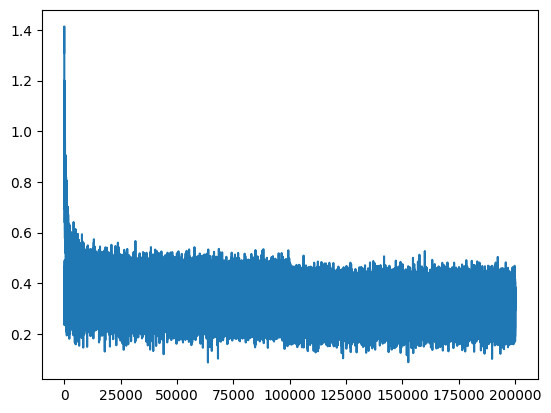

In [94]:
plt.plot(stepi,lossi)

In [74]:
#plt.plot(lri, lossi)

In [95]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.0744, grad_fn=<NllLossBackward0>)

In [96]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1305, grad_fn=<NllLossBackward0>)

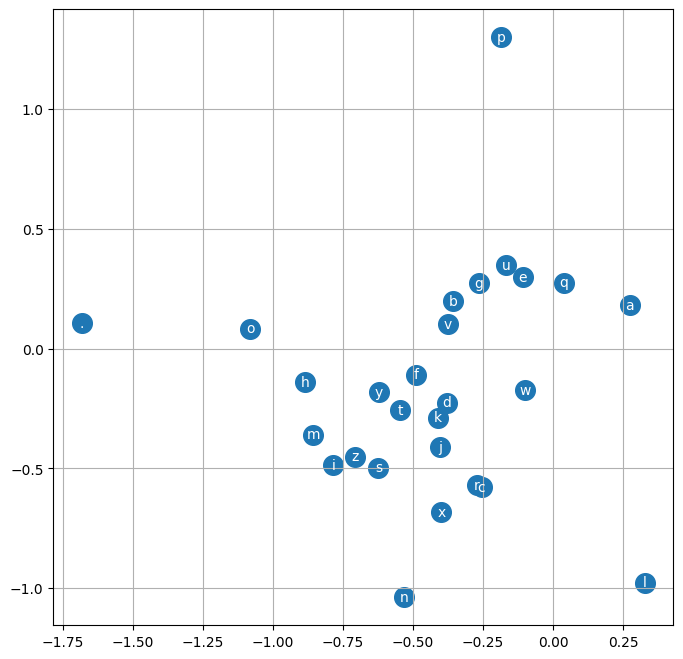

In [92]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [28]:
# training split , validation split , test split
#     80%                 10%             10%


In [97]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [98]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mona.
kayanniellen.
hayah.
rethrus.
jernegan.
chedo.
lillemy.
jenreigh.
edo.
naraelyzion.
kalin.
shorergianaiel.
kin.
renleigh.
terorius.
kacdi.
kymeri.
els.
kayshis.
kyla.
